In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 256
#epochs = 2000
use_gpu = True
lr = 0.001
weight_decay = 10

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [6]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)

X_test = X_test.drop(columns=['building_id'], axis=1)

In [7]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

### scale y

In [8]:
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_eval = y_scaler.fit_transform(y_eval.values.reshape(-1, 1))

## Imputer, Scaler, Feature selection

In [9]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])



/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
print(X_train.shape)
X_train = pipeline.fit_transform(X_train)
X_eval = pipeline.fit_transform(X_eval)

print(X_test.shape)
X_test = pipeline.fit_transform(X_test)


(42000, 233)
(10000, 233)


In [11]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [13]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [14]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        
        self.bn = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        return x

In [15]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [16]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = criterion(batch_y, pred)
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return model,  np.array(train_loss).mean()


'''
def train_func(model, loader, accumlation_steps=32):
    model.train()
    optim.zero_grad()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        
        train_loss.append(loss.item())
        
        loss = loss / accumlation_steps
        loss.backward()
        
        if step % accumlation_steps == 0 or step == len(loader)-1:
            optim.step()
            optim.zero_grad()

    print('training loss', np.array(train_loss).mean())
    return model, np.array(train_loss).mean()
'''
'''
Batch update
'''
'''
def train_func(model, loader, accumlation_steps=64):
    model.train()
    optim.zero_grad()
    train_loss = []
    loss = 0
    for step, (batch_x, batch_y) in enumerate(loader):
        pred = model(batch_x)
        current_loss = criterion(pred, batch_y)
        loss = loss + current_loss
        train_loss.append(current_loss.item())
        if (step+1) % accumlation_steps == 0 or (step+1) == len(loader):
            optim.zero_grad()
            loss.backward()
            optim.step()
            loss = 0
            
    print('training loss', np.array(train_loss).mean())
    return model, np.array(train_loss).mean()
'''

def eval_func(model, loader):
    model.eval()
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
        print('testing loss', loss.item())
    return loss

def test_func(model, X, y_scaler=None):
    model.eval()
    
    with torch.no_grad():
        pred = model(X)
        pred = pred.cpu().numpy()
        
        if y_scaler != None:
            pred = y_scaler.inverse_transform(pred)
    return pred
    

In [17]:
train_losses = []
eval_losses = []
for t in range(1000):
    print('epochs', t)
    model, train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        eval_losses.append(eval_loss)
    
        train_losses.append(train_loss)
    

epochs 0
training loss 0.9696782969389901
epochs 1
training loss 0.9558965637828365
epochs 2
training loss 0.9426293732316205
epochs 3
training loss 0.9324218726519382
epochs 4
training loss 0.9243700959691495
epochs 5
training loss 0.9322924703811154
epochs 6
training loss 0.8927599435897939
epochs 7
training loss 0.8954966425669916
epochs 8
training loss 0.9147192544219169
epochs 9
training loss 0.8914165996692397
testing loss 0.47191205620765686
epochs 10
training loss 0.8822792624885386
epochs 11
training loss 0.9268415016206828
epochs 12
training loss 0.8708887058225545
epochs 13
training loss 0.8939837876763759
epochs 14
training loss 0.900047460356445
epochs 15
training loss 0.8950549548774055
epochs 16
training loss 0.8627909118253173
epochs 17
training loss 0.8577375261621042
epochs 18
training loss 0.834116233659513
epochs 19
training loss 0.8399248943635912
testing loss 0.050722360610961914
epochs 20
training loss 0.8751480320186326
epochs 21
training loss 0.8377745288565304

training loss 0.7589053017849272
epochs 178
training loss 0.7888844865741151
epochs 179
training loss 0.7663882438432087
testing loss 0.033137910068035126
epochs 180
training loss 0.7971468713247415
epochs 181
training loss 0.7200472382433487
epochs 182
training loss 0.78898378992171
epochs 183
training loss 0.7400187294817332
epochs 184
training loss 0.816977693174373
epochs 185
training loss 0.7875857910197792
epochs 186
training loss 0.8387227143979434
epochs 187
training loss 0.8389405898749829
epochs 188
training loss 0.768824141337113
epochs 189
training loss 0.8098635145660603
testing loss 0.03940748795866966
epochs 190
training loss 0.7977760834224297
epochs 191
training loss 0.7659119168465788
epochs 192
training loss 0.8284418168393048
epochs 193
training loss 0.8528337243379969
epochs 194
training loss 0.7931744569178784
epochs 195
training loss 0.7623884223175771
epochs 196
training loss 0.7828399166239031
epochs 197
training loss 0.7624050816351717
epochs 198
training loss

training loss 0.40404372137378564
epochs 352
training loss 0.6326258818534287
epochs 353
training loss 0.6886680460788986
epochs 354
training loss 0.5615142038374236
epochs 355
training loss 0.5883813279257579
epochs 356
training loss 0.3694535415506724
epochs 357
training loss 0.5422136182360577
epochs 358
training loss 0.7457009149320197
epochs 359
training loss 0.7011915077540007
testing loss 0.0482654869556427
epochs 360
training loss 0.7440229077795238
epochs 361
training loss 0.5550508361987092
epochs 362
training loss 0.5534038797698237
epochs 363
training loss 0.715769908238541
epochs 364
training loss 0.5713976755512483
epochs 365
training loss 0.6256101616855824
epochs 366
training loss 0.6672537801392151
epochs 367
training loss 0.5393443075770682
epochs 368
training loss 0.785448406117432
epochs 369
training loss 0.7814983574504202
testing loss 0.14961567521095276
epochs 370
training loss 0.7665744742209261
epochs 371
training loss 0.8181591709229079
epochs 372
training los

training loss 0.7760016656960502
epochs 526
training loss 0.7839040388437835
epochs 527
training loss 0.7447820689416293
epochs 528
training loss 0.6912479375799497
epochs 529
training loss 0.7208919156455632
testing loss 0.045459989458322525
epochs 530
training loss 0.750191208404122
epochs 531
training loss 0.5810901645909656
epochs 532
training loss 0.9747076096859846
epochs 533
training loss 0.649740840528499
epochs 534
training loss 0.589250672653769
epochs 535
training loss 0.45390208033901275
epochs 536
training loss 0.41676941866224465
epochs 537
training loss 0.43841527768156746
epochs 538
training loss 0.4855924070558765
epochs 539
training loss 0.642920352541136
testing loss 0.07044908404350281
epochs 540
training loss 0.5998444501423474
epochs 541
training loss 0.398011593277933
epochs 542
training loss 0.4301517925817858
epochs 543
training loss 0.42300958143490736
epochs 544
training loss 0.36263389887683317
epochs 545
training loss 0.38881941877982834
epochs 546
training

training loss 0.550422288703196
testing loss 0.12354177236557007
epochs 700
training loss 0.4962615865649599
epochs 701
training loss 0.3244867500595071
epochs 702
training loss 0.48763151841633245
epochs 703
training loss 0.47110255913752497
epochs 704
training loss 0.8737083275209774
epochs 705
training loss 0.6393310109322722
epochs 706
training loss 0.5534334696829319
epochs 707
training loss 0.42308536966641747
epochs 708
training loss 0.4861727605037617
epochs 709
training loss 0.4633408426448251
testing loss 0.05149076133966446
epochs 710
training loss 0.6707125010589758
epochs 711
training loss 0.5901159196640506
epochs 712
training loss 0.5528922149177754
epochs 713
training loss 0.38899111754514953
epochs 714
training loss 0.38411917038487664
epochs 715
training loss 0.7200171604752541
epochs 716
training loss 0.40819498563016005
epochs 717
training loss 0.5737046627835793
epochs 718
training loss 0.5656148929939125
epochs 719
training loss 0.4343581258799091
testing loss 0.1

training loss 0.43975442428932043
epochs 873
training loss 0.3485821225398192
epochs 874
training loss 0.40921380296349524
epochs 875
training loss 0.40428965705813785
epochs 876
training loss 0.40148240221720755
epochs 877
training loss 0.3446140543529482
epochs 878
training loss 0.4515705408020453
epochs 879
training loss 0.4675469616823124
testing loss 0.2906549572944641
epochs 880
training loss 0.38503928498336765
epochs 881
training loss 0.4244536585541386
epochs 882
training loss 0.4312699963649114
epochs 883
training loss 0.7604758418644919
epochs 884
training loss 0.4454026042737744
epochs 885
training loss 0.3437604021845442
epochs 886
training loss 0.4470448218286037
epochs 887
training loss 0.6694687189026313
epochs 888
training loss 0.540355376639601
epochs 889
training loss 0.36542794517043864
testing loss 0.27251705527305603
epochs 890
training loss 0.7367700859904289
epochs 891
training loss 0.44535731354897673
epochs 892
training loss 0.5049029887287002
epochs 893
train

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)

## overfitting

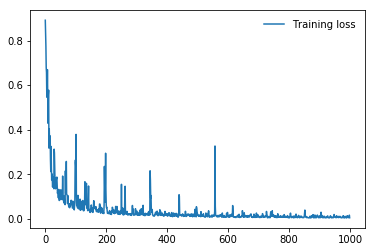

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

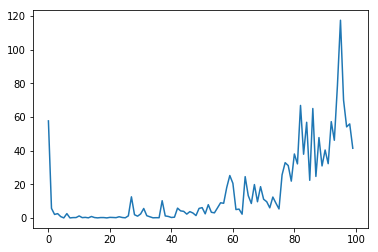

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

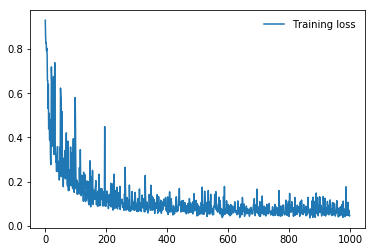

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

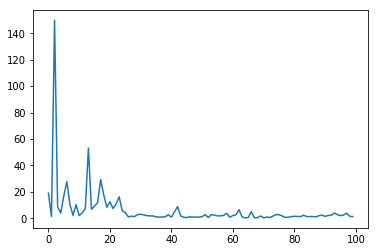

In [19]:
plt.plot(eval_losses, label='Validation loss')


## vaildation

In [20]:
eval_func(model, eval_loader)

testing loss 1.678534746170044


tensor(1.6785, device='cuda:0')

### Submission

In [22]:
pred = test_func(model, X_test, y_scaler)
pred

array([[ 7.8621939e+08],
       [ 7.2142335e+06],
       [ 1.1949832e+07],
       ...,
       [-9.6227256e+05],
       [ 2.3039574e+08],
       [ 8.8473740e+06]], dtype=float32)

In [23]:

submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)

### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512